  # Rainfall Prediction from weather data

As a part this assignment i have collected data from different weather stations from Australian government website http://www.bom.gov.au/

Canberra   http://www.bom.gov.au/climate/dwo/201505/html/IDCJDW2801.201505.shtml

Melbourne  http://www.bom.gov.au/climate/dwo/IDCJDW3033.latest.shtml

For all other regions data can be collected from http://www.bom.gov.au/climate/dwo/index.shtml    

###  Data Set Creation

Data collected from different source has been saved in different folders for better organization of data . But for rain prediction task it is important to bring all data together. Code below merges data from various location to a single csv/dataframe.

More data can be added in respective director as data grows without changing program.

In [197]:
import glob
%matplotlib inline
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import  linear_model
from collections import OrderedDict
import pandas as pd
import statsmodels.formula.api as sm

# get data file names


pipe_del_file=""
output_model_file=""
training_set=""
test_set=""
future_set=""
path_Canbera =r''
path_Melbourne =r''
path_Queensland =r''

filenames_Queensland = glob.glob(path_Queensland + "/*.csv")

dfs = []
for filename in filenames_Queensland:
    dfs.append(pd.read_csv(filename))

# Concatenate all data into one DataFrame
frame_Queensland = pd.concat(dfs, ignore_index=True)


filenames_Canbera = glob.glob(path_Canbera + "/*.csv")

dfs_c = []
for filename in filenames_Canbera:
    dfs_c.append(pd.read_csv(filename))

# Concatenate all data into one DataFrame
frame_Canbera = pd.concat(dfs_c, ignore_index=True)


filenames_Melbourne = glob.glob(path_Melbourne + "/*.csv")

dfs_m = []
for filename in filenames_Melbourne:
    dfs_m.append(pd.read_csv(filename))

# Concatenate all data into one DataFrame
frame_Melbourne = pd.concat(dfs_m, ignore_index=True)

frames = [frame_Queensland,frame_Canbera,frame_Melbourne]
training= pd.concat(frames)  ##Concatenate all data


## Cleaning Data

### Renaming Columns

In [198]:
training.columns = ['Station', 'Date', 'Min_temp', 'Max_temp' , 'Rainfall' , 'Evoporation','Sunshine ', 'Dir_max_wind_gust', 'Speed_max_wind_gust' , 'Time_max_wind_gust' ,'temp_9am','hum_9am','cloud_9am','wind_dir_9am','wind_speed_9am','press_9am' , 'temp_3pm','hum_3pm','cloud_3pm','wind_dir_3pm','wind_speed_3pm','press_3pm' ] 


###  Imputation

Since predicting rainfall is a regression task so its compulsary to convert all qualitative data to numberical values .
 

In [199]:
training['Dir_max_wind_gust'] = pd.Categorical(training.Dir_max_wind_gust).codes
training['wind_dir_9am'] = pd.Categorical(training.wind_dir_9am).codes
training['wind_dir_3pm'] = pd.Categorical(training.wind_dir_3pm).codes
training['wind_speed_9am'] = pd.Categorical(training.wind_speed_9am).codes
training['Month'] =  pd.DatetimeIndex(training['Date']).month


### Droping columns having no data

In [200]:
training=training.drop(training.columns[[5,6]], axis=1)

Apart from that lot of values in dataset are null or have missing values . But we cannot discard all rows that have missing value. So it compulsary to fill these values using some of the numerical methods .I have used mean to fill all missing values.


In [201]:
training=training.fillna(training.mean())


Now our data set is ready . We must save it for reusing.


In [202]:
training.to_csv("data/output/training_output.csv")

## Creating Training set and test set

In [203]:
from sklearn.cross_validation import train_test_split
training, test_data = train_test_split(training, test_size = 0.3)
test_data, test_data_future = train_test_split(test_data, test_size = 0.2)
training.to_csv(training_set)
test_data.to_csv(test_set)
test_data_future.to_csv(future_set)

### Specifying input and output columns for Models

In [204]:
input_columns = np.array(['Station', 'Min_temp', 'Max_temp' ,'hum_9am','cloud_9am','press_9am' , 'temp_3pm','hum_3pm','cloud_3pm','press_3pm','Month'])
output_column = 'Rainfall'


## Making Predictive Models

In [205]:
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# Ordinary lest square regression
linear_regr = linear_model.LinearRegression()
# Linear regression
from sklearn.linear_model import Ridge
ridge = Pipeline([('anova',SelectKBest(f_regression,k=10)),('ridge',Ridge(alpha=1))])
# Random forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=3, max_features='sqrt', max_depth=2000)
# Gradient Boosting Regression Trees
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=10, learning_rate=0.001, loss='lad', max_depth=6)


## Fitting Predictive Model

In [206]:

#Print "Fitting OLS"
lfit=linear_regr.fit(training[input_columns], training[output_column])
#print "Fitting ridge"
ridge.fit(training[input_columns], training[output_column])
#print "Fitting random forest"
rf.fit(training[input_columns], training[output_column])
#print "Fitting gradient boosted regression"
gbr.fit(training[input_columns], training[output_column])



GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.001,
             loss='lad', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, presort='auto',
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

### Variable of importance for Random Forest and Gradient Boosting

In [207]:
rf_var_importance_rankings = np.argsort(rf.feature_importances_)[::-1]
gbr_var_importance_rankings = np.argsort(gbr.feature_importances_)[::-1]

print ("Random Forest".ljust(34) + " Gradient Boosting".ljust(35))
for r, g in zip(rf_var_importance_rankings[:15],gbr_var_importance_rankings[:15]):
    print ("{0}: {1:0.3f} | {2}: {3:0.3f}".format(input_columns[r].ljust(25), 
                                 rf.feature_importances_[r],
                                 input_columns[g].ljust(25),
                                 gbr.feature_importances_[g]))


Random Forest                      Gradient Boosting                 
Max_temp                 : 0.194 | hum_9am                  : 0.260
hum_9am                  : 0.160 | press_9am                : 0.250
press_3pm                : 0.148 | press_3pm                : 0.155
Min_temp                 : 0.108 | Max_temp                 : 0.128
temp_3pm                 : 0.101 | Min_temp                 : 0.122
press_9am                : 0.097 | temp_3pm                 : 0.044
hum_3pm                  : 0.064 | hum_3pm                  : 0.032
Month                    : 0.055 | cloud_9am                : 0.006
cloud_3pm                : 0.047 | Month                    : 0.003
Station                  : 0.020 | cloud_3pm                : 0.000
cloud_9am                : 0.005 | Station                  : 0.000


### Finding Mean absolute error

In [208]:
def mean_absolute_error(forecast, obs):
    return np.mean(np.abs(forecast - obs))
predictions = {}
predictions['Random Forest'] = rf.predict(test_data[input_columns])
predictions['Gradient Boosting'] = gbr.predict(test_data[input_columns])
predictions['Ridge'] = gbr.predict(test_data[input_columns])
predictions['OLS'] = linear_regr.predict(test_data[input_columns])
for model_name, preds in predictions.iteritems():
    print (model_name.ljust(20) + "{0:0.3f}".format(mean_absolute_error(preds, test_data[output_column])))
    


OLS                 1.882
Ridge               1.370
Random Forest       1.804
Gradient Boosting   1.370


### Plotting fitting for Actual vs Predicted values for different models

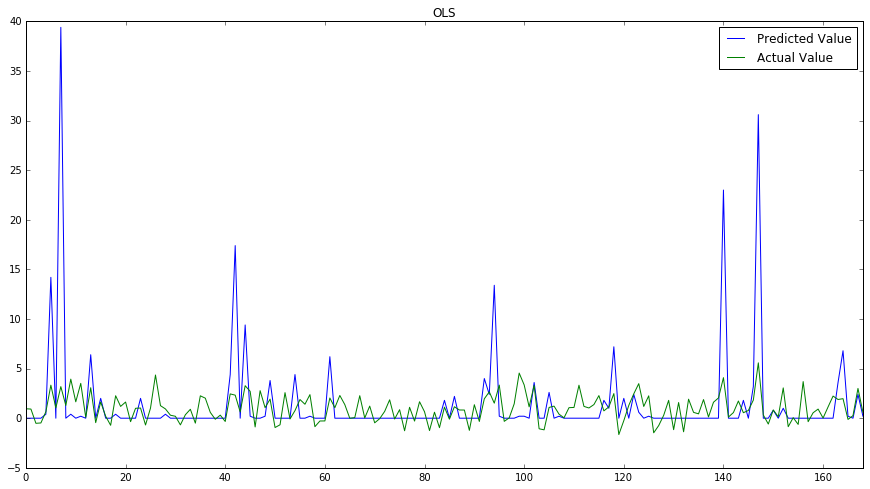

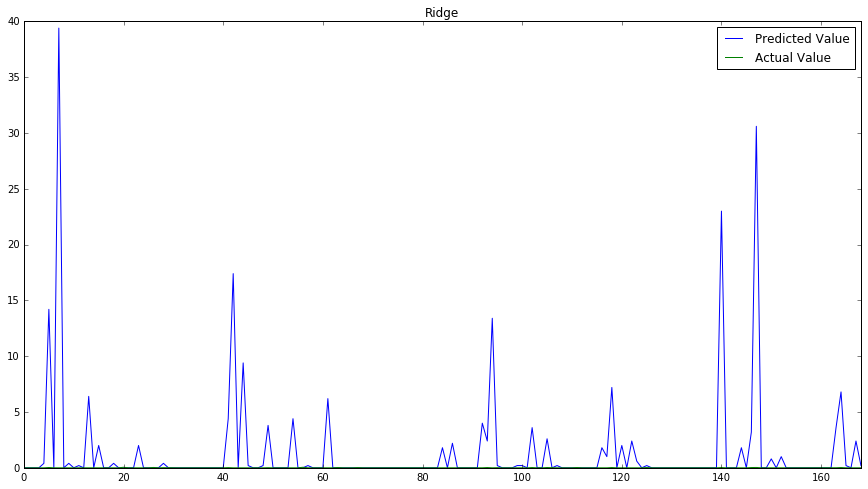

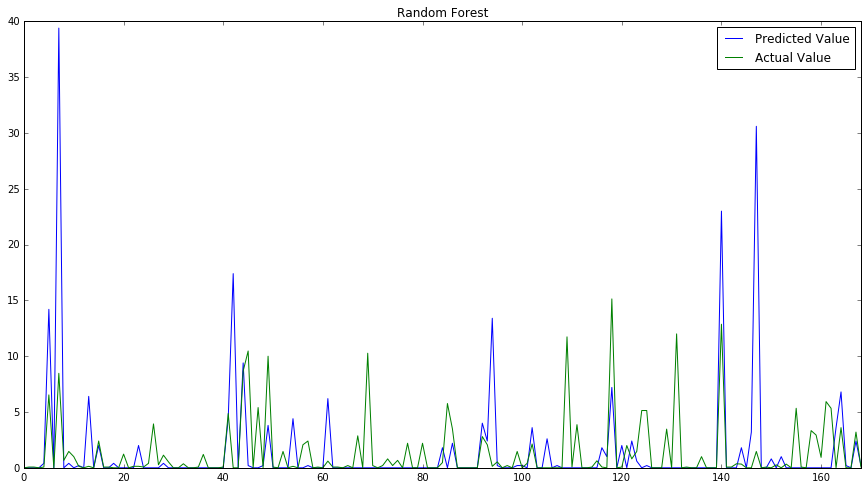

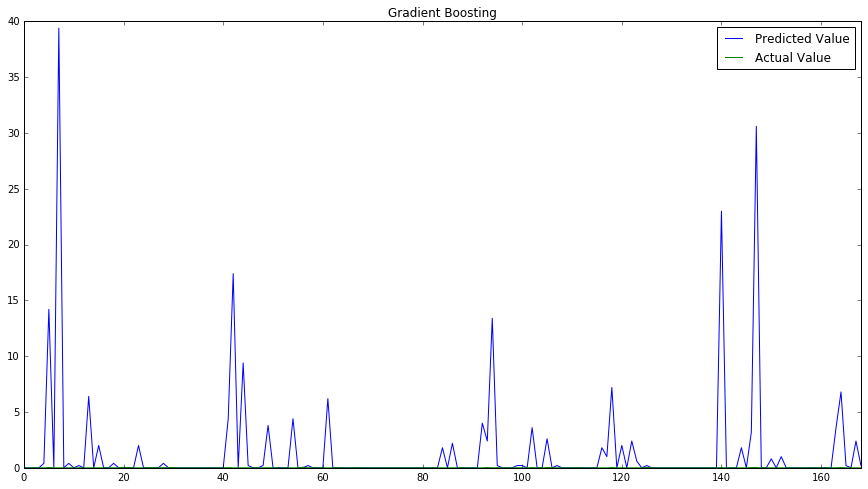

In [209]:
for model_name, preds in predictions.iteritems():
    output_data1=pd.DataFrame( test_data[output_column]);
    output_data1.columns=['Predicted Value']
    output_data2=pd.DataFrame( predictions[model_name]);
    output_data2.columns=['Actual Value']
    output_data1 = output_data1.reset_index(drop=True)
    output_data2 = output_data2.reset_index(drop=True)
    output_result = pd.concat([output_data1, output_data2], axis=1)
    output_result.plot(label=model_name , figsize=(15, 8 )).set_title(model_name)
    result = pd.concat([output_data1, output_data2], axis=1)
    result.to_csv(output_model_file+model_name.strip()+".csv")    

### Creating Dataset for submission

Mapping Station Code to three letter IATA  Code



In [210]:
y = lambda sym: {39123: 'QUN', 86338: 'MAL', 70351: 'CAN' ,66022 : 'SYD' ,40842 : 'BRI'}.get(sym)

In [211]:
training_apply=training
training_apply['Station_IATA'] = training_apply['Station'].apply(y)
training_apply['Station']=training_apply['Station_IATA'] 
training_apply=training_apply.drop('Station_IATA', axis=1)


Formatting Date

In [212]:
training_apply['Date'] =  pd.to_datetime(training_apply['Date']).apply(lambda x: x.strftime('%d-%m-%Y'))


Creating input pipe delimeted for submision

In [213]:
training_apply.to_csv(pipe_del_file, sep='|')


## Conclusion

Based on this analysis both model Ridge Regression or Gradient Boosting can be used as they offer lower error rates.
But it’s highly recommended to use other models as well before deciding one among all other models.
To reach a final decision few other things are recommended like
Verifying multicollinearity among all other predictors.
Bias and variance should also be checked.
Model should be trained with more data.